# [CSC8101] Engineering for AI - 2025 Spark Coursework

**Name:** *PRANAV SUNIL RAJA*  

**Student Number** *240408545*

## Coursework overview

### Inputs

- **NYC Taxi Trips dataset** - list of recorded taxi trips, each with several characteristics, namely: distance, number of passengers, origin zone, destination zone and trip cost (total amount charged to customer).
- **NYC Zones dataset** - list of zones wherein trips can originate/terminate.

### Tasks

1. Data cleaning
  1. Remove "0 distance" and 'no passengers' records.
  2. Remove outlier records.
2. Add new columns
  1. Join with zones dataset
  2. Compute the unit profitability of each trip
3. Zone summarisation and ranking
  1. Summarise trip data per zone
  2. Obtain the top 10 ranks according to:
    1. The total trip volume
    2. Their average profitabilitiy
    3. The total passenger volume
4. Record the total and task-specific execution times for each dataset size and format.

### How to

###### Code structure and implementation

- You must implement your solution to each task in the provided function code skeleton.
- The task-specific functions are combined together to form the full pipeline code, executed last (do not modify this code).
- Before implementing the specified function skeleton, you should develop and test your solution on separate code cells (create and destroy cells as needed).

###### Development

- Develop an initial working solution for the 'S' dataset and only then optimise it for larger dataset sizes.
- To perform vectorised operations on a DataFrame:
  - use the API docs to look for existing vectorised functions in: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html
  - if a customised function is required (e.g. to add a new column based on a linear combination of other columns), implement your own User Defined Function (UDF). See:  https://spark.apache.org/docs/latest/sql-ref-functions-udf-scalar.html
- Use only the `pyspark.sql` API - documentation link below - (note that searching through the docs returns results from the `pyspark.sql` API together with the `pyspark.pandas` API):
  - https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/frame.html
- Periodically download your notebook to your computer as backup and safety measure against accidental file deletion.

###### Execution time measurement

- Execution time is calculated and returned by the Spark Engine and shown in the output region of the cell.
- To measure the execution time of a task you must perform a `collect` or similar operation (e.g. `take`) on the returned DataFrame.

The following codeblock is used to mount the google colab instance to your google drive, in which we will be accessing the data provided in the course.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 0 - Read data

The code below is ready to run. **Do not modify this code**. It does the following:

- Reads the 'zones' dataset into variable 'zone_names'
- Defines the `init_trips` function that allows you to read the 'trips' dataset (from the DBFS FileStore) given the dataset size ('S' to 'XXL') as function argument
- Defines the `pipeline` function, called in Task 4 to measure the execution time of the entire data processing pipeline
- Shows you how to call the `init_trips` function and display dataset characteristics (number of rows, schema)

In [2]:
!pip install findspark

In [3]:
## global imports
import pyspark.sql as ps
import pyspark.sql.functions as pf
import pandas as pd
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# Load zone names dataset - (much faster to read small file from git than dbfs)
zones_file_url = 'https://raw.githubusercontent.com/NewcastleComputingScience/csc8101-coursework/main/02-assignment-spark/taxi_zone_names.csv'
zone_names = spark.createDataFrame(pd.read_csv(zones_file_url))

# Function to load trips dataset by selected dataset size
def init_trips(size = 'S'):

    files = {
        'S'  : ['2021_07'],
        'M'  : ['2021'],
        'L'  : ['2020_21'],
        'XL' : ['1_6_2019', '7_12_2019'],
        'XXL': ['1_6_2019', '7_12_2019', '2020_21']
    }

    # validate input dataset size
    if size not in files.keys():
        print("Invalid input dataset size. Must be one of {}".format(list(files.keys())))
        return None

    filenames = list(map(lambda s: f'/content/drive/MyDrive/CSC8101_Data/tripdata_{s}.parquet', files[size]))
    trips_df = spark.read.parquet(filenames[0])

    for name in filenames[1:]:
        trips_df = trips_df.union(spark.read.parquet(name))


    print(
    """
    Trips dataset loaded!
    ---
      Size: {s}
      Tables loaded: {ds}
      Number of trips (dataset rows): {tc:,}
    """.format(s = size, ds = filenames, tc = trips_df.count()))

    return trips_df

# helper function to print dataset row count
def print_count(df):
    print("Row count: {t:,}".format(t = df.count()))

def pipeline(trips_df, with_task_12 = False, zones_df = zone_names):
    # Do not edit
    #---

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df = zone_names)

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph)

    _top10_trips     = t32_top10_trips(_zones)
    _top10_profit    = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)

    return([_top10_trips, _top10_profit, _top10_passenger])

In [5]:
# CHANGE the value of argument 'size' to record the pipeline execution times for increasing dataset sizes
SIZE = 'M'


# Load trips dataset
trips = init_trips(SIZE)

# uncomment line only for small datasets
# trips.take(1)


    Trips dataset loaded!
    ---
      Size: M
      Tables loaded: ['/content/drive/MyDrive/CSC8101_Data/tripdata_2021.parquet']
      Number of trips (dataset rows): 15,571,166
    


In [6]:
print_count(trips)

Row count: 15,571,166


In [7]:
# dataset schemas
trips.printSchema()

root
 |-- index: long (nullable = true)
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |--

In [8]:
display(trips[['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount']].take(5))

[Row(PULocationID=142, DOLocationID=43, trip_distance=2.1, passenger_count=1.0, total_amount=11.8),
 Row(PULocationID=238, DOLocationID=151, trip_distance=0.2, passenger_count=1.0, total_amount=4.3),
 Row(PULocationID=132, DOLocationID=165, trip_distance=14.7, passenger_count=1.0, total_amount=51.95),
 Row(PULocationID=138, DOLocationID=132, trip_distance=10.6, passenger_count=0.0, total_amount=36.35),
 Row(PULocationID=68, DOLocationID=33, trip_distance=4.94, passenger_count=1.0, total_amount=24.36)]

In [9]:
zone_names.printSchema()

root
 |-- LocationID: long (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [10]:
display(zone_names.take(5))

[Row(LocationID=1, Borough='EWR', Zone='Newark Airport', service_zone='EWR'),
 Row(LocationID=2, Borough='Queens', Zone='Jamaica Bay', service_zone='Boro Zone'),
 Row(LocationID=3, Borough='Bronx', Zone='Allerton/Pelham Gardens', service_zone='Boro Zone'),
 Row(LocationID=4, Borough='Manhattan', Zone='Alphabet City', service_zone='Yellow Zone'),
 Row(LocationID=5, Borough='Staten Island', Zone='Arden Heights', service_zone='Boro Zone')]

## Task 1 - Filter rows

**Input:** trips dataset

### Task 1.1 - Remove "0 distance" and 'no passengers' records

Remove dataset rows that represent invalid trips:

- Trips where `trip_distance == 0` (no distance travelled)
- Trips where `passenger_count == 0` and `total_amount == 0` (we want to retain records where `total_amount` > 0 - these may be significant as the taxi may have carried some parcel, for example)

Altogether, a record is removed if it satisfies the following conditions:

`trip_distance == 0` or `(passenger_count == 0` and `total_amount == 0)`.

**Recommended:** Select only the relevant dataset columns for this and subsequent tasks: `['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount')]`

### Task 1.2 - Remove outliers using the modified z-score

Despite having removed spurious "zero passengers" trips in task 1.1, columns `total_amount` and `trip_distance` contain additional outlier values that must be identified and removed.

To identify and remove outliers, you will use the modified [z-score](https://en.wikipedia.org/wiki/Standard_score) method.
The modified z-score uses the median and [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD), instead of the mean and standard deviation, to determine how far an observation (indexed by i) is from the mean:

$$z_i = \frac{x_i - \mathit{median}(\mathbf{x})}{\mathbf{MAD}},$$

where x represents the input vector, xi is an element of x and zi is its corresponding z-score. In turn, the MAD formula is:

$$\mathbf{MAD} = 1.483 * \mathit{median}(\big\lvert x_i - \mathit{median}(\mathbf{x})\big\rvert).$$

Observations with **high** (absolute) z-score are considered outlier observations. A score is considered **high** if its __absolute z-score__ is larger than a threshold T = 3.5:

$$\big\lvert z_i \big\rvert > 3.5.$$

where T represents the number of unit standard deviations beyond which a score is considered an outlier ([wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

This process is repeated twice, once for each of the columns `total_amount` and `trip_distance` (in any order).

**Important:** Use the surrogate function [`percentile_approx`](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.functions.percentile_approx.html?highlight=percentile#pyspark.sql.functions.percentile_approx) to estimate the median (calculating the median values for a column is expensive as it cannot be parallelised efficiently).

In [ ]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

In [11]:
# Your solution implementation to task 1.1 goes HERE
def t11_remove_zeros(df):
    # Select only relevant columns
    df = df.select("PULocationID", "DOLocationID", "trip_distance", "passenger_count", "total_amount")

    # Ensure correct data types (avoids issues with string-based filtering)
    df = df.withColumn("trip_distance", pf.col("trip_distance").cast("double")) \
           .withColumn("passenger_count", pf.col("passenger_count").cast("int")) \
           .withColumn("total_amount", pf.col("total_amount").cast("double"))

    # Apply filtering conditions:
    df_filtered = df.filter(
        (pf.col("trip_distance") > 0) &
        ~((pf.col("passenger_count") == 0) & (pf.col("total_amount") == 0))
    )

    return df_filtered

In [12]:
# execute task 1.1
trips_11 = t11_remove_zeros(trips)

print_count(trips_11)

## uncomment only for smaller datasets
# display(trips_11.take(10))

Row count: 15,350,075


In [13]:
# Your solution implementation to task 1.2 goes HERE
def t12_remove_outliers(df):

    # Function to calculate the modified z-score and filter out outliers
    def remove_outliers_from_column(df, column):
        # Calculate median
        median_value = df.select(pf.percentile_approx(column, 0.5)).first()[0]

        # Calculate MAD
        mad_value = (
            df.select(pf.expr(f"1.483 * percentile_approx(abs({column} - {median_value}), 0.5)")).first()[0]
        )

        # Calculate modified z-score
        df = df.withColumn("modified_z_score",
                           (pf.col(column) - median_value) / mad_value)

        # Filter outliers
        df_filtered = df.filter(pf.abs(pf.col("modified_z_score")) <= 3.5)

        # Drop the modified z-score column
        return df_filtered.drop("modified_z_score")

    # Remove outliers from total_amount
    df = remove_outliers_from_column(df, "total_amount")

    # Remove outliers from trip_distance
    df = remove_outliers_from_column(df, "trip_distance")

    return df

In [14]:
# execute task 1.2
trips_12 = t12_remove_outliers(trips_11)

print_count(trips_12)
# display(trips_12.take(10))

Row count: 13,277,877


## Task 2 - Compute new columns

### Task 2.1 - Zone names

Obtain the **start** and **end** zone names of each trip by joining the `trips` and `zone_names` datasets (i.e. by using the `zone_names` dataset as lookup table).

**Note:** The columns containing the start and end zone ids of each trip are named `PULocationID` and `DOLocationID`, respectively.

### Task 2.2 - Unit profitability

Compute the column `unit_profitabilty = total_amount / trip_distance`.

In [ ]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

In [15]:
# Your solution implementation to task 2.1 goes HERE
def t21_join_zones(df, zones_df=zone_names):
    """
    Joins the trips DataFrame with the zone_names DataFrame to obtain
    the start and end zone names for each trip.

    Args:
        df (DataFrame): The trips DataFrame (output of Task 1.2).
        zones_df (DataFrame): The zone_names DataFrame containing zone information.

    Returns:
        DataFrame: The joined DataFrame with additional columns for start and end zone names.
    """
    # Join the trips DataFrame with the zone_names DataFrame for start zone
    df = df.join(zones_df, df.PULocationID == zones_df.LocationID, how="left") \
            .drop(zones_df.LocationID)  # Drop the duplicated LocationID column

    # Rename the start zone column
    df = df.withColumnRenamed("Zone", "StartZone")

    # Join the trips DataFrame with the zone_names DataFrame for end zone
    df = df.join(zones_df, df.DOLocationID == zones_df.LocationID, how="left") \
            .drop(zones_df.LocationID)  # Drop the duplicated LocationID column

    # Rename the end zone column
    df = df.withColumnRenamed("Zone", "EndZone")

    return df

In [16]:
# execute task 2.1
trips_21 = t21_join_zones(trips_12, zones_df = zone_names)

print_count(trips_21)
# display(trips_21.take(10))

Row count: 13,277,877


In [17]:
# Your solution implementation to task 2.2 goes HERE
def t22_calc_profit(df):
    # Calculate unit profitability, while avoiding division by zero errors
    df = df.withColumn(
        "unit_profitability",
        pf.when(pf.col("trip_distance") != 0, pf.col("total_amount") / pf.col("trip_distance"))
        .otherwise(None)  # Set to None or 0 if trip_distance is zero
    )
    return df

In [18]:
# execute task 2.2
trips_22 = t22_calc_profit(trips_21)

print_count(trips_22)
# display(trips_22.take(10))

Row count: 13,277,877


## Task 3: Rank zones by traffic, passenger volume and profitability

### 3.1 - Summarise interzonal travel

Build a graph data structure of zone-to-zone traffic, representing aggregated data about trips between any two zones. The graph will have one node for each zone and one edge connecting each pair of zones. In addition, edges contain aggregate information about all trips between those zones.

For example, zones Z1 and Z2 are connected by *two* edges: edge Z1 --> Z2 carries aggregate data about all trips that originated in Z1 and ended in Z2, and edge Z2 --> Z2 carries aggregate data about all trips that originated in Z2 and ended in Z1.

The aggregate information of interzonal travel must include the following data:

- `average_unit_profit` - the average unit profitability (calculated as `mean(unit_profitabilty)`).
- `trips_count` -- the total number of recorded trips.
- `total_passengers` -- the total number of passenger across all trips (sum of `passenger_count`).

This graph can be represented as a new dataframe, with schema:

\[`PULocationID`, `DOLocationID`, `average_unit_profit`, `trips_count`, `total_passengers` \]

__hint__: the `groupby()` operator produces a `pyspark.sql.GroupedData` structure. You can then calculate multiple aggregations from this using `pyspark.sql.GroupedData.agg()`:
- https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.groupby.html
- https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.GroupedData.agg.html

### Task 3.2 - Obtain top-10 zones

For each of the following measures, report the top-10 zones _using their plain names you dereferenced in the previous step, not the codes_. Note that this requires ranking the nodes in different orders. Specifically, you need to calculate the following further aggregations:

- the **total** number of trips originating from Z. This is simply the sum of `trips_count` over all outgoing edges for Z, i.e., edges of the form Z -> \*
- the **average** profitability of a zone. This is the average of all `average_unit_profit` over all *outgoing* edges from Z.
- The **total** passenger volume measured as the **sum** of `total_passengers` carried in trips that originate from Z

In [ ]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

In [19]:
## Your solution to task 3.1 goes HERE
def t31_summarise_trips(df):

    # Group by origin and destination locations (PULocationID and DOLocationID)
    df_summarised = df.groupBy("PULocationID", "DOLocationID").agg(
        # Calculate average unit profitability
        pf.avg("unit_profitability").alias("average_unit_profit"),

        # Count the number of trips
        pf.count("unit_profitability").alias("trips_count"),

        # Sum the number of passengers
        pf.sum("passenger_count").alias("total_passengers")
    )

    return df_summarised


In [20]:
# execute task 3.1
graph = t31_summarise_trips(trips_22)

print_count(graph)
# display(graph.take(10))

Row count: 15,270


In [21]:
# Your solution to task 3.2 goes HERE (implement each of the functions below)
def t32_summarise_zones_pairs(df, zones_df=zone_names):

    # Group by origin (PULocationID) and aggregate metrics
    zone_summary = df.groupBy("PULocationID").agg(
        # Total number of trips originating from each zone
        pf.sum("trips_count").alias("total_trips"),

        # Average profitability for the zone
        pf.avg("average_unit_profit").alias("average_profitability"),

        # Total number of passengers for trips originating from the zone
        pf.sum("total_passengers").alias("total_passenger_volume")
    )

    # Join with zone names to get the plain names of the zones
    result = zone_summary.join(zones_df, zone_summary.PULocationID == zones_df.LocationID, how="left") \
        .drop(zones_df.LocationID)  # Drop the duplicated LocationID column

    result.cache()
    return result


# Top 10 ranked zones by traffic (trip volume)
def t32_top10_trips(df_zones):
    df_sorted = df_zones.orderBy(pf.desc("total_trips")).limit(10)
    df_sorted.show()  # Debugging step
    return df_sorted.select("Zone", "total_trips").toPandas()

# Top 10 ranked zones by profit
def t32_top10_profit(df_zones):
    df_sorted = df_zones.orderBy(pf.desc("average_profitability")).limit(10)
    df_sorted.show()  # Debugging step
    return df_sorted.select("Zone", "average_profitability").toPandas()

# Top 10 ranked zones by passenger volume
def t32_top10_passenger(df_zones):
    df_sorted = df_zones.orderBy(pf.desc("total_passenger_volume")).limit(10)
    df_sorted.show()  # Debugging step
    return df_sorted.select("Zone", "total_passenger_volume").toPandas()

In [22]:
# execute task 3.2
zones = t32_summarise_zones_pairs(graph)

print("Total rows in zones:", zones.count())

top10_trips     = t32_top10_trips(zones)
top10_profit    = t32_top10_profit(zones)
top10_passenger = t32_top10_passenger(zones)

Total rows in zones: 262
+------------+-----------+---------------------+----------------------+----------+---------+--------------------+------------+
|PULocationID|total_trips|average_profitability|total_passenger_volume|LocationID|  Borough|                Zone|service_zone|
+------------+-----------+---------------------+----------------------+----------+---------+--------------------+------------+
|         237|     744823|    8.268309733602804|               1031330|       237|Manhattan|Upper East Side S...| Yellow Zone|
|         236|     698432|       9.614691292714|                967495|       236|Manhattan|Upper East Side N...| Yellow Zone|
|         161|     469331|    7.989590029406091|                650112|       161|Manhattan|      Midtown Center| Yellow Zone|
|         186|     459861|    8.595460640361217|                635555|       186|Manhattan|Penn Station/Madi...| Yellow Zone|
|         142|     448472|    43.25784528168865|                629166|       142|Manh

In [24]:
# use 'display()' or return a pandas DataFrame for 'pretty' output
display(top10_trips)

,Zone,total_trips
0,Upper East Side South,744823
1,Upper East Side North,698432
2,Midtown Center,469331
3,Penn Station/Madison Sq West,459861
4,Lincoln Square East,448472
5,Upper West Side South,444632
6,Murray Hill,441061
7,Lenox Hill West,440117
8,Midtown East,419586
9,Union Sq,377839


In [25]:
# use 'display()' return a pandas DataFrame for 'pretty' output
display(top10_profit)

,Zone,average_profitability
0,Bay Terrace/Fort Totten,201.47
1,Mariners Harbor,197.77
2,East Flushing,119.52
3,Rossville/Woodrow,111.56
4,Newark Airport,94.13
5,West Brighton,87.37
6,Rosedale,87.17
7,Jamaica Estates,85.96
8,Bay Ridge,84.68
9,Springfield Gardens North,84.01


In [26]:
# use 'display()' or return a pandas DataFrame for 'pretty' output
display(top10_passenger)

,Zone,total_passenger_volume
0,Upper East Side South,1031330
1,Upper East Side North,967495
2,Midtown Center,650112
3,Penn Station/Madison Sq West,635555
4,Lincoln Square East,629166
5,Upper West Side South,627604
6,Lenox Hill West,608393
7,Murray Hill,605190
8,Midtown East,575590
9,Union Sq,527654


<ipython-input-27-c94d0c568901>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["Zone"], x=df[column], palette=color)


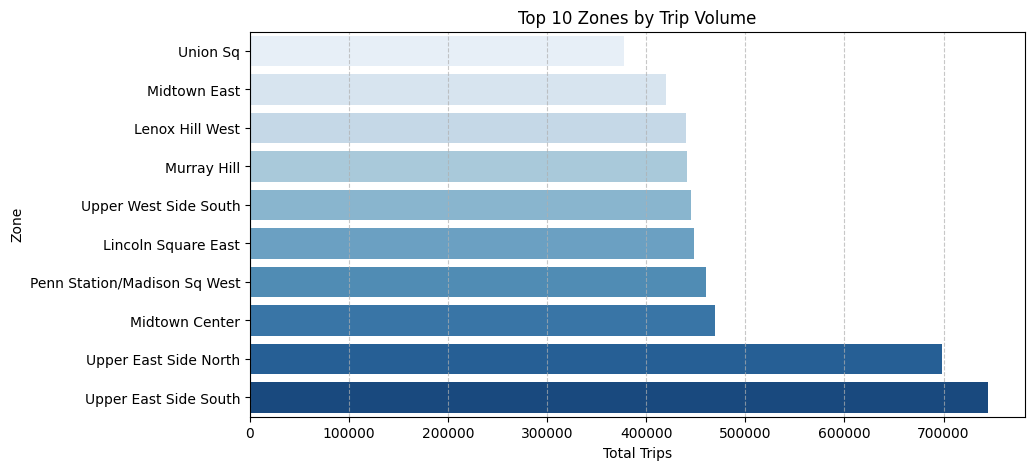

<ipython-input-27-c94d0c568901>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["Zone"], x=df[column], palette=color)


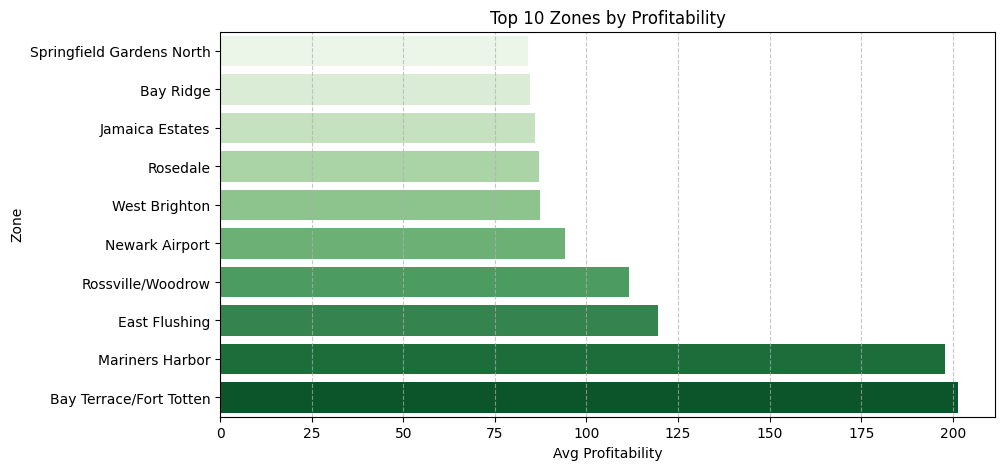

<ipython-input-27-c94d0c568901>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["Zone"], x=df[column], palette=color)


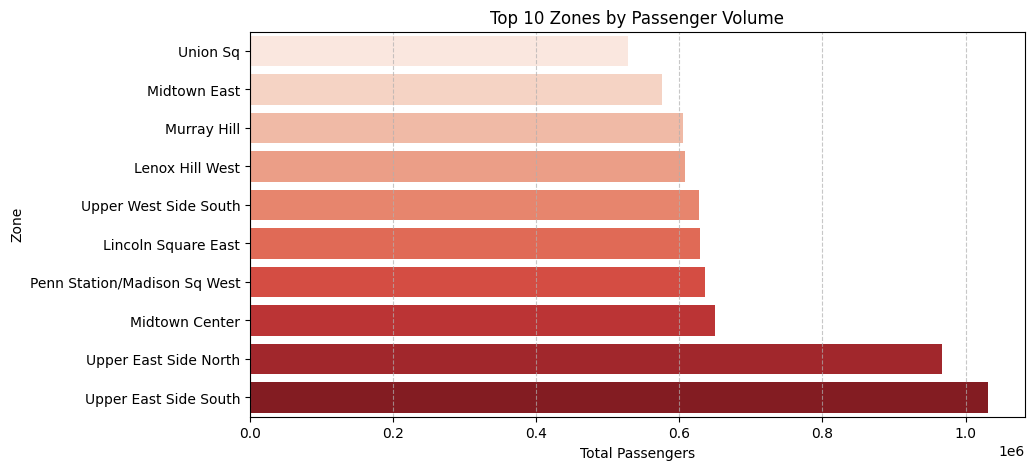

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the obtained resuslts

def plot_top10(df, column, title, ylabel, color="skyblue"):

    df = df.sort_values(by=column, ascending=True)  # Ensure correct order
    plt.figure(figsize=(10, 5))
    sns.barplot(y=df["Zone"], x=df[column], palette=color)
    plt.xlabel(ylabel)
    plt.ylabel("Zone")
    plt.title(title)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

# Plot top 10 zones by trip volume
plot_top10(top10_trips, "total_trips", "Top 10 Zones by Trip Volume", "Total Trips", color="Blues")

# Plot top 10 zones by average profitability
plot_top10(top10_profit, "average_profitability", "Top 10 Zones by Profitability", "Avg Profitability", color="Greens")

# Plot top 10 zones by passenger volume
plot_top10(top10_passenger, "total_passenger_volume", "Top 10 Zones by Passenger Volume", "Total Passengers", color="Reds")



## Task 4 - Record the pipeline's execution time

Record the execution time of:

1. the whole pipeline
2. the whole pipeline except task 1.2

on the two tables below, for all dataset sizes: `'S'`, `'M'`, `'L'`, `'XL'`, `'XXL'`.

Analyse the resulting execution times and comment on the effect of dataset size, dataset format and task complexity (with and without task 1.2) on pipeline performance.

In [34]:
# after developing your solution, it may be convenient to combine all your functions in a single cell (at the start or end of the notebook)

# CHANGE the value of the following arguments to record the pipeline execution times for increasing dataset sizes
SIZE = 'S'
WITH_TASK_12 = False

# Load trips dataset
trips = init_trips(SIZE)


    Trips dataset loaded!
    ---
      Size: S
      Tables loaded: ['/content/drive/MyDrive/CSC8101_Data/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    


In [35]:
# run and record the resulting execution time shown by databricks (on the cell footer)

# IMPORTANT: this function calls all task functions in order of occurrence. For this code to run without errors, you have to load into memory all of the previous task-specific functions, even if you haven't implemented these yet.
pipeline(trips, with_task_12 = WITH_TASK_12)

+------------+-----------+---------------------+----------------------+----------+---------+--------------------+------------+
|PULocationID|total_trips|average_profitability|total_passenger_volume|LocationID|  Borough|                Zone|service_zone|
+------------+-----------+---------------------+----------------------+----------+---------+--------------------+------------+
|         237|     126914|    5.314942798960623|                176823|       237|Manhattan|Upper East Side S...| Yellow Zone|
|         236|     109037|    5.062816338145955|                151051|       236|Manhattan|Upper East Side N...| Yellow Zone|
|         132|     106810|    5.968529838209491|                166344|       132|   Queens|         JFK Airport|    Airports|
|         186|     102944|    6.266048077409884|                145815|       186|Manhattan|Penn Station/Madi...| Yellow Zone|
|         161|      98719|    5.724931176342403|                141981|       161|Manhattan|      Midtown Cente

[                           Zone  total_trips
 0         Upper East Side South       126914
 1         Upper East Side North       109037
 2                   JFK Airport       106810
 3  Penn Station/Madison Sq West       102944
 4                Midtown Center        98719
 5                   Murray Hill        93838
 6                  Midtown East        90173
 7           Lincoln Square East        84772
 8                  Clinton East        80614
 9         Upper West Side South        78706,
                           Zone  average_profitability
 0               Newark Airport                 279.37
 1              Highbridge Park                  74.32
 2                Prospect Park                  60.31
 3             Sunset Park East                  50.07
 4              Columbia Street                  42.47
 5    Saint George/New Brighton                  27.75
 6  Heartland Village/Todt Hill                  27.44
 7                    Bay Ridge                  27.4

_Table 1. Pipeline performance for `parquet` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    |  2.8 |  15.5 |  000 |  000 |  000 |
| execution time   (w/o 1.2)  | 23.00 | 37.00 | 0.00 | 0.00 | 0.00 |
| execution time              | 39.00 | 120.00 | 0.00 | 0.00 | 0.00 |
| sec / 1M records (w/o 1.2)  | 8.21  | 2.38  | 0.0  | 0.0  | 0.0  |
| sec / 1M records            | 13.92  | 7.74  | 0.0  | 0.0  | 0.0  |

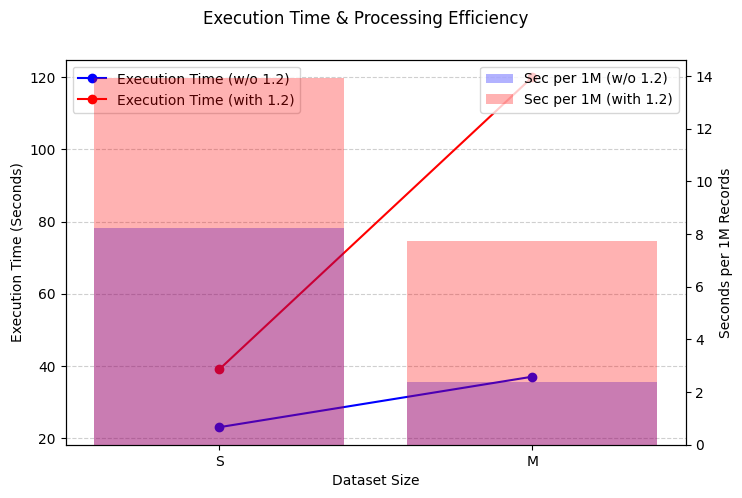

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data (Only for S and M datasets)
sizes = ["S", "M"]
execution_time_wo_12 = [23, 37]  # Execution time without Task 1.2
execution_time_with_12 = [39, 120]  # Execution time with Task 1.2
sec_per_m_wo_12 = [8.21, 2.38]  # Sec per 1M records (w/o 1.2)
sec_per_m_with_12 = [13.92, 7.74]  # Sec per 1M records (with 1.2)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Execution Time on primary y-axis (Left)
ax1.plot(sizes, execution_time_wo_12, "bo-", label="Execution Time (w/o 1.2)")
ax1.plot(sizes, execution_time_with_12, "ro-", label="Execution Time (with 1.2)")
ax1.set_xlabel("Dataset Size")
ax1.set_ylabel("Execution Time (Seconds)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left")

# Create second y-axis (Right) for Processing Efficiency
ax2 = ax1.twinx()
ax2.bar(sizes, sec_per_m_wo_12, color="blue", alpha=0.3, label="Sec per 1M (w/o 1.2)")
ax2.bar(sizes, sec_per_m_with_12, color="red", alpha=0.3, label="Sec per 1M (with 1.2)")
ax2.set_ylabel("Seconds per 1M Records", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Legends and title
fig.suptitle("Execution Time & Processing Efficiency")
ax2.legend(loc="upper right")
ax1.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


**References:**


*   Used a bit of help from Generative AI for plotting the graph of TASK-4

